In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/ml-turbulence-dataset/komega.csv')

In [3]:
features = ['komega_I1_1','komega_I2_1','komega_I1_2','komega_I2_2','komega_I1_27','komega_I2_7']
label = ['labels_uu']

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
df_val = df[df.Case == 'PHLL_case_1p0']
df_test = df[df.Case == 'PHLL_case_1p2']

def preprocess_dataset(df,features,labels):
    df_train = df[(df.Case.isin(['PHLL_case_0p5','PHLL_case_0p8','PHLL_case_1p5']))]
    df_val = df[df.Case == 'PHLL_case_1p0']
    df_test = df[df.Case == 'PHLL_case_1p2']
        
    train_features = torch.Tensor(df_train[features].values)
    train_labels = torch.Tensor(df_train[labels].values)
    
    val_features = torch.Tensor(df_val[features].values)
    val_labels = torch.Tensor(df_val[labels].values)
    
    test_features = torch.Tensor(df_test[features].values)
    test_labels = torch.Tensor(df_test[labels].values)
    
    feature_scaler = StandardScaler()
    x_train = torch.Tensor(feature_scaler.fit_transform(train_features))
    x_val = torch.Tensor(feature_scaler.transform(val_features))
    x_test = torch.Tensor(feature_scaler.transform(test_features))

    label_scaler = StandardScaler()
    y_train = torch.Tensor(label_scaler.fit_transform(train_labels))
    y_val = torch.Tensor(label_scaler.transform(val_labels))
    y_test = torch.Tensor(label_scaler.transform(test_labels))    
    return x_train, y_train, x_val, y_val, x_test, y_test, feature_scaler, label_scaler


def evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, label_scaler):
    fig = plt.figure(figsize=(15, 5), constrained_layout=True)
    gs = fig.add_gridspec(2, 2, hspace=0., wspace=0.1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    model.eval()

    train_predictions = model.forward(x_train).detach().cpu().numpy()
    val_predictions = model.forward(x_val).detach().cpu().numpy()
    test_predictions = model.forward(x_test).detach().cpu().numpy()

    train_predictions = label_scaler.inverse_transform(train_predictions)
    val_predictions = label_scaler.inverse_transform(val_predictions)
    test_predictions = label_scaler.inverse_transform(test_predictions)

    train_labels = label_scaler.inverse_transform(y_train.detach().cpu().numpy())
    val_labels = label_scaler.inverse_transform(y_val.detach().cpu().numpy())
    test_labels = label_scaler.inverse_transform(y_test.detach().cpu().numpy())

    print(f'Training set score: {mean_squared_error(train_labels, train_predictions)}')
    print(f'Validation set score: {mean_squared_error(val_labels, val_predictions)}')
    print(f'TEST SET SCORE: {mean_squared_error(test_labels, test_predictions)}')
    print('=========================')

    ax1.tricontourf(df_val['komega_Cx'], df_val['komega_Cy'], val_predictions[:, 0], vmax=5E-5, vmin=-5E-5)
    ax1.set_aspect(1)
    ax1.set_title('Predictions - validation set')

    ax2.tricontourf(df_val['komega_Cx'], df_val['komega_Cy'], df_val['labels_uu'], vmax=5E-5, vmin=-5E-5)
    ax2.set_aspect(1)
    ax2.set_title('Truth - validation set')

    ax3.tricontourf(df_test['komega_Cx'], df_test['komega_Cy'], test_predictions[:, 0], vmax=5E-5, vmin=-5E-5)
    ax3.set_aspect(1)
    ax3.set_title('Predictions - test set')

    ax4.tricontourf(df_test['komega_Cx'], df_test['komega_Cy'], df_test['labels_uu'], vmax=5E-5, vmin=-5E-5)
    ax4.set_aspect(1)
    ax4.set_title('Truth - test set')

#     return train_predictions, val_predictions, test_predictions, train_labels, val_labels, test_labels


## LSTM (Long Short-Term Memory) Implementation
LSTM is a type of recurrent neural network (RNN) architecture, designed to model sequential data and address the vanishing gradient problem of traditional RNNs. It's particularly effective for tasks involving time-series data, natural language processing, speech recognition, and more. LSTM networks consist of memory cells with self-connected units called gates, which regulate the flow of information. These gates include input, output, and forget gates, allowing LSTMs to selectively retain or forget information over long sequences. This enables LSTMs to capture long-term dependencies in data and effectively learn patterns across various time scales.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

class LSTM1D(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM1D, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        device = next(self.parameters()).device
        x = x.to(device)
        
        # Add sequence dimension
        x = x.unsqueeze(1)
        
        # Reshape input to be (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.input_size)
        
        # Pass through LSTM
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                  torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        
        out, _ = self.lstm(x, hidden)
        
        # Use output from last timestep for prediction
        out = self.fc1(out[:, -1, :])
        
        return out

def train_neural_network(model, x_train, y_train, x_val, y_val, n_epochs, loss_fn=nn.MSELoss(), optimizer=optim.SGD, lr=0.001, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = optimizer(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience = 5
    wait = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            predicted_y = model.forward(x_batch)
            if predicted_y.size(0) != y_batch.size(0):
                continue
            loss = loss_fn(predicted_y, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                predicted_y = model.forward(x_batch)
                if predicted_y.size(0) != y_batch.size(0):
                    continue
                val_loss += loss_fn(predicted_y, y_batch).item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model

In [6]:
features = ['komega_I1_1','komega_I2_1','komega_I1_2','komega_I2_2','komega_I1_27','komega_I2_7']
labels = ['labels_uu']
x_train, y_train, x_val, y_val, x_test, y_test, feature_scaler, label_scaler = preprocess_dataset(df,features,labels)

model = LSTM1D(input_size=6, hidden_size=64, num_layers=2, output_size=1)

train_neural_network(model, x_train, y_train, x_val, y_val, n_epochs=10)

Epoch 1/10: Train Loss: 0.9986, Val Loss: 0.8305


Epoch 2/10: Train Loss: 0.9855, Val Loss: 0.8164


Epoch 3/10: Train Loss: 0.9657, Val Loss: 0.7911


Epoch 4/10: Train Loss: 0.9273, Val Loss: 0.7420


Epoch 5/10: Train Loss: 0.8510, Val Loss: 0.6489


Epoch 6/10: Train Loss: 0.7384, Val Loss: 0.5504


Epoch 7/10: Train Loss: 0.6585, Val Loss: 0.5156


Epoch 8/10: Train Loss: 0.6350, Val Loss: 0.5095


Epoch 9/10: Train Loss: 0.6285, Val Loss: 0.5045


Epoch 10/10: Train Loss: 0.6240, Val Loss: 0.4985


LSTM1D(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)

Training set score: 1.5547961529360776e-10
Validation set score: 1.2465993515231588e-10
TEST SET SCORE: 1.309030245311149e-10


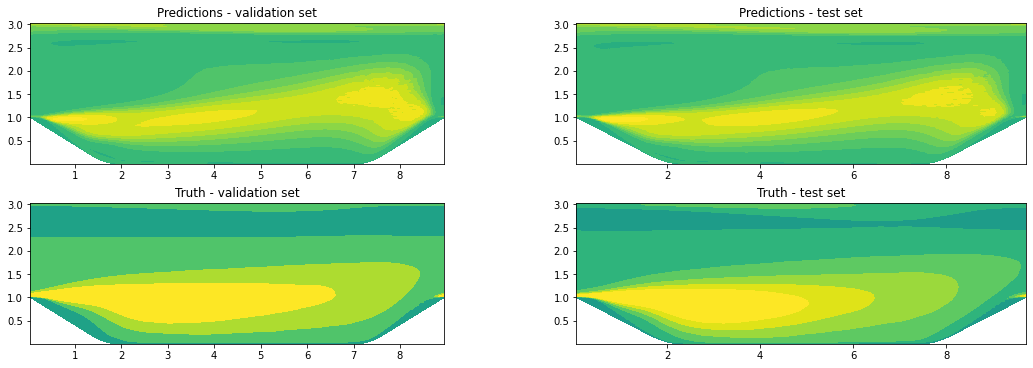

In [7]:
evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test, label_scaler)